In [15]:
# Libraries for data handling, web scaping, NLP and for plotting  
import feedparser
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [16]:
# (1) Setting it up and collecting the data 

# The market index, used BBC News RSS feed as its good and structured source for the UK
market_ticker = '^FTSE'
start_date = '2022-01-01'
end_date = '2024-12-31'

# Download historical market data for the FTSE 100.
print("Downloading FTSE 100 historical data...")
market_data = yf.download(market_ticker, start=start_date, end=end_date)
print("Download complete.")


C:\Users\iyb21127\AppData\Local\Temp\ipykernel_38852\4137568186.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  market_data = yf.download(market_ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Download complete.


In [17]:
#(2) Data Simulation

# NOTE: Live news feeds (like RSS) only provide the most recent headlines and are not
# suitable for historical analysis. To build a functioning model, we will simulate
# having historical sentiment data. A real-world version of this project would
# use a dedicated news API to get past headlines. But I did not want to spend any money for this...

print("\nSimulating historical sentiment data...")
# Create a new DataFrame with the same dates as our market data.
daily_sentiment = pd.DataFrame(index=market_data.index)

# Generate synthetic sentiment scores. We'll use a normal distribution
# centred slightly above zero to mimic a generally neutral-to-positive news environment.
np.random.seed(42) # Using a 'seed' means we get the same "random" numbers every time.
daily_sentiment['sentiment'] = np.random.normal(loc=0.05, scale=0.1, size=len(market_data))
print("Synthetic sentiment data created.")
print(daily_sentiment.head())
    


Simulating historical sentiment data...
Synthetic sentiment data created.
            sentiment
Date                 
2022-01-04   0.099671
2022-01-05   0.036174
2022-01-06   0.114769
2022-01-07   0.202303
2022-01-10   0.026585


In [18]:
# (3) Preparing the data

# Calculate the daily percentage returns for the FTSE 100.
market_data['returns'] = market_data['Close'].pct_change()

# Now, merge the two DataFrames (our synthetic sentiment and market returns).
# They share the same index, so this will align perfectly.
merged_data = pd.merge(daily_sentiment, market_data['returns'], left_index=True, right_index=True, how='inner')
merged_data.rename(columns={'returns': 'market_returns'}, inplace=True)

# Also, create a 'lagged' return column to test if today's news
# affects tomorrow's market price.
merged_data['next_day_returns'] = merged_data['market_returns'].shift(-1)

# Drop any rows with missing values that might have been created.
merged_data.dropna(inplace=True)

print("\nMerged sentiment and market data:")
print(merged_data.head())


Merged sentiment and market data:
            sentiment  market_returns  next_day_returns
Date                                                   
2022-01-05   0.036174        0.001559         -0.008847
2022-01-06   0.114769       -0.008847          0.004684
2022-01-07   0.202303        0.004684         -0.005344
2022-01-10   0.026585       -0.005344          0.006192
2022-01-11   0.026586        0.006192          0.008049


In [19]:
# (4) The Correlation Analysis 

# Now for the key statistical test. We'll calculate the Pearson correlation
# coefficient between our sentiment score and the market returns.
# This value ranges from -1 to +1.
#   - A value near +1 means strong positive correlation.
#   - A value near -1 means strong negative correlation.
#   - A value near 0 means no correlation.

same_day_corr = merged_data['sentiment'].corr(merged_data['market_returns'])
next_day_corr = merged_data['sentiment'].corr(merged_data['next_day_returns'])

print("\n--- Correlation Results ---")
print(f"Correlation between sentiment and SAME-DAY market returns: {same_day_corr:.4f}")
print(f"Correlation between sentiment and NEXT-DAY market returns: {next_day_corr:.4f}")


--- Correlation Results ---
Correlation between sentiment and SAME-DAY market returns: -0.0241
Correlation between sentiment and NEXT-DAY market returns: 0.0055


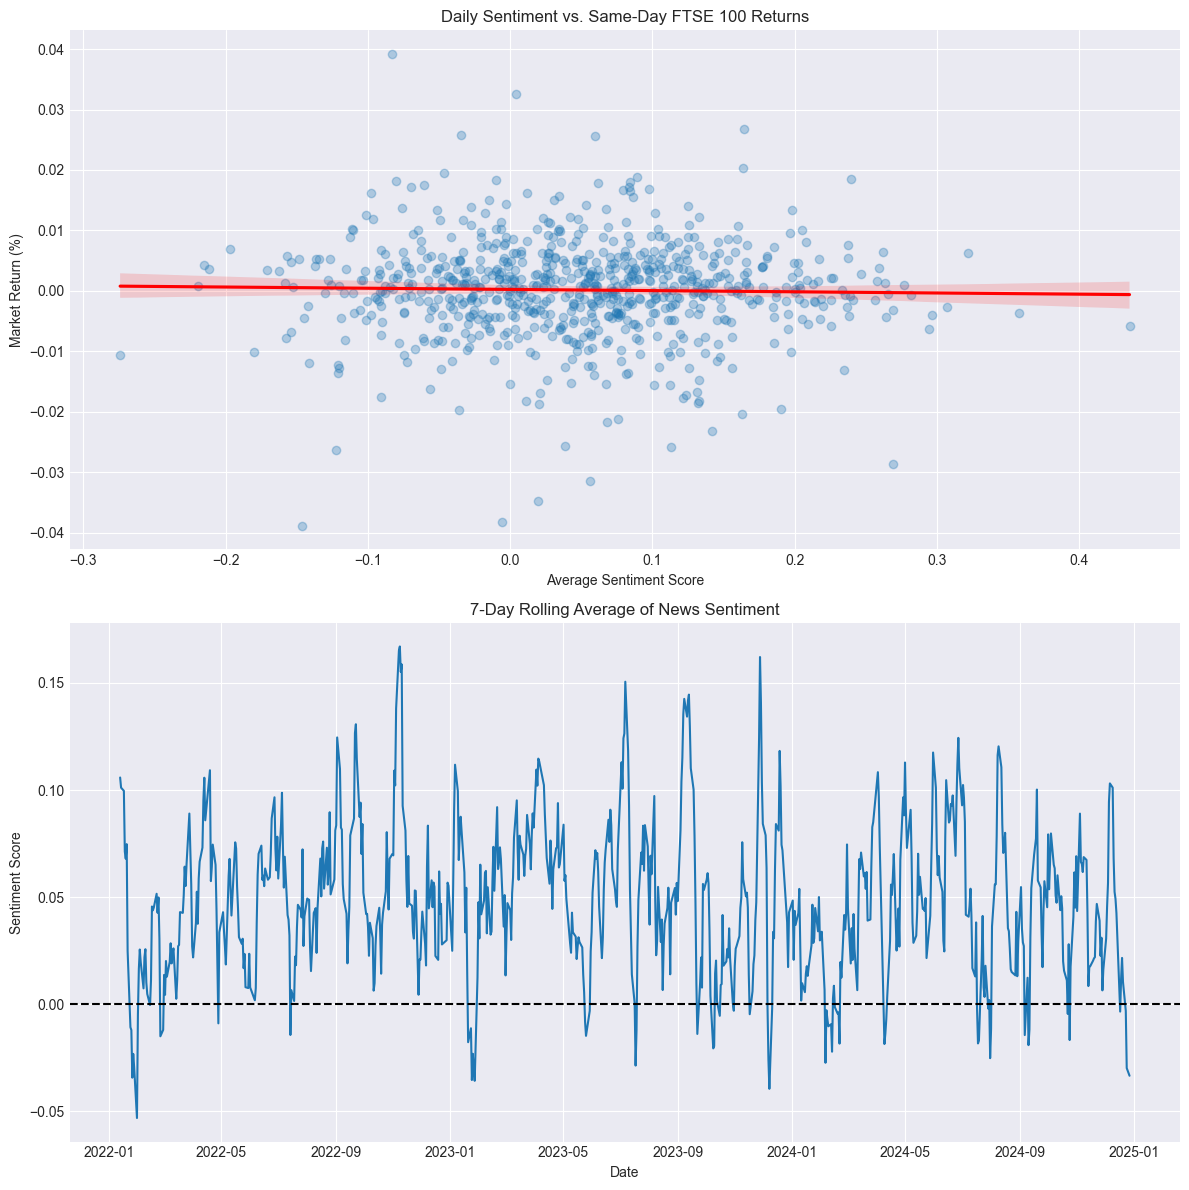

In [20]:
# (5) Plotting and final analysis of this

# Set a plot style for a nicer look.
plt.style.use('seaborn-v0_8-darkgrid')
# Create a figure with two subplots.
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Plot 1: A scatter plot to visualise the correlation.
# If there's a relationship, we should see a pattern (e.g., a line).
# If not, it will just look like a random cloud of dots.
sns.regplot(x='sentiment', y='market_returns', data=merged_data, ax=ax1,
            scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
ax1.set_title('Daily Sentiment vs. Same-Day FTSE 100 Returns')
ax1.set_xlabel('Average Sentiment Score')
ax1.set_ylabel('Market Return (%)')

# Plot 2: A time series of the sentiment score over time.
# This helps us see if there were periods of particularly high or low sentiment.
ax2.plot(merged_data['sentiment'].rolling(window=7).mean()) # Using a 7-day average to smooth it out.
ax2.axhline(0, color='black', linestyle='--')
ax2.set_title('7-Day Rolling Average of News Sentiment')
ax2.set_xlabel('Date')
ax2.set_ylabel('Sentiment Score')

plt.tight_layout()
plt.show()